# Assignment
- Student name: Mai Pham
- Medium Post: https://medium.com/@maipham95hanu/voices-of-the-105th-congress-a-deep-dive-into-senatorial-speech-similarities-9e24fe24ce64
- GitHub re

In [1]:
import os
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import concurrent.futures
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import random
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

## 0. Preprocessing data

In [2]:
# Data directory
data_folder_path = "../Inputs/105-extracted-date"
# Get a list of English stopwords
#stop_words = set(stopwords.words('english'))
stop_words = set(stopwords.words('english')) | {'president'} 

Before that I only used stop word lists to remove unhelpful words from speeches. When performing word cloud, I realized that the word President appeared most often. I reviewed the original data and found that this word should be included in the stop word because it is not really useful in the process of analyzing similarities between speeches. So in the stopword list in the context of this exercise I add the word "president"

In [3]:
#CREATE FUNCTIONS TO PROCESS FILES AND SPEECH
# Update the preprocessing function to remove stopwords, punctuation, and convert to lowercase
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    text = re.sub(r'\d', '', text)  # Remove digits
    word_tokens = word_tokenize(text)  # Tokenize
    # Remove stopwords and words with lengths < 3
    filtered_text = [word for word in word_tokens if word not in stop_words and len(word) > 3]
    return ' '.join(filtered_text)

# Function to extract and preprocess content from each speech
def preprocess_speech(file_path):
    with open(file_path, 'r', encoding='latin1') as file:
        content = file.read()
    speeches = content.split("<DOC>")[1:]  # Remove the first line and split each speech
    speeches.reverse()  # Reverse the order to sort by time
    # Apply text preprocessing to each speech
    processed_speeches = [preprocess_text(text[text.find('<TEXT>') + 6:text.find('</TEXT>')].strip()) for text in speeches]
    return " ".join(processed_speeches)


In [4]:
# Dictionary to store preprocessed speech content of each senator
senator_speeches_preprocessed = {}

# Biden's file name to ensure it is processed first
biden_filename = "105-biden-de.txt"

# Ensure processing Biden's speech first
biden_file_path = os.path.join(data_folder_path, biden_filename)
senator_speeches_preprocessed[biden_filename] = preprocess_speech(biden_file_path)

# Then, process other speeches
for file_name in os.listdir(data_folder_path):
    if file_name != biden_filename:  # Ensure not processing Biden again
        file_path = os.path.join(data_folder_path, file_name)
        senator_speeches_preprocessed[file_name] = preprocess_speech(file_path)

# Separate into a list of file names and corresponding contents for convenient analysis later
file_names = list(senator_speeches_preprocessed.keys())
speech_contents = list(senator_speeches_preprocessed.values())


## 1. Using cosine similarity

In [5]:
# Use TF-IDF to vectorize the entire speech
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(speech_contents)

# Calculate the cosine similarity between Biden's speech (first) and all other speeches
cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix).flatten()

# Find the speech closest to Biden's, excluding the first speech (by Biden himself)
closest_index = cosine_similarities.argsort()[-2]  # -1 is Biden's own speech, -2 is the closest
closest_speech = file_names[closest_index]
closest_similarity = cosine_similarities[closest_index]
print(f"The closest speech to Biden's is {closest_speech} with a similarity of {closest_similarity}")

# Create a DataFrame from cosine similarity
similarities_df = pd.DataFrame({'FileName': file_names, 'Similarity_Original': cosine_similarities})

# Remove Biden's speech from DataFrame
similarities_df = similarities_df[similarities_df.FileName != biden_filename]

# Sort DataFrame by decreasing similarity
similarities_df = similarities_df.sort_values(by='Similarity_Original', ascending=False)
top_5_similar_speeches = similarities_df.head(5)

# Top 5 similar speeches
print(top_5_similar_speeches)


The closest speech to Biden's is 105-kyl-az.txt with a similarity of 0.8007857604089371
                FileName  Similarity_Original
61        105-kyl-az.txt             0.800786
66  105-lieberman-ct.txt             0.772468
59      105-kerry-ma.txt             0.765797
81    105-roberts-ks.txt             0.758998
51  105-hutchison-tx.txt             0.746853


In [6]:
# Importing data 'sen105kh' to see if the most similar speeches belong to senators from the same state and/or party
df_sen105kh = pd.read_csv('https://raw.githubusercontent.com/thimaipham/Data/main/sen105kh_fix.csv', sep=';')

# Find information of Biden and Kyl in the DataFrame
biden_info = df_sen105kh[df_sen105kh['lname'].str.lower() == 'biden']
kyl_info = df_sen105kh[df_sen105kh['lname'].str.lower() == 'kyl']

# Print the results
print(biden_info)
print(kyl_info)


    cong  lname stateab   lstate     id  dist  party
14   105  biden      de  DELAWAR  14101     0    100
   cong lname stateab   lstate     id  dist  party
4   105   kyl      az  ARIZONA  15429     0    200


##### Insights
- The speech most similar to Biden's, with a cosine similarity score of approximately 0.801, belongs to Senator Kyl from Arizona, highlighting interesting cross-party and cross-state parallels in their speech content.
- Despite the high similarity in their speeches, Biden and Kyl hail from different states—Delaware and Arizona, respectively—and represent opposing political parties, Biden being a Democrat and Kyl a Republican.
- This finding reveals the nuanced and sometimes surprising ways in which political discourse can overlap, transcending party lines and geographical boundaries, even among senators from distinctly different political spectrums and regions.


## 2. Stemming or Lemmatization
##### 2.1. STEMMING

In [7]:
ps = PorterStemmer()

def stem_text(text):
    word_tokens = word_tokenize(text)
    stemmed_text = ' '.join([ps.stem(word) for word in word_tokens])
    return stemmed_text

# Apply stemming method to all speeches
speech_contents_stemmed = [stem_text(speech) for speech in speech_contents]


###### It takes 2 minutes and 18 seconds to run in my enviroment

##### 2.2. LEMMATIZATION

In [8]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    word_tokens = word_tokenize(text)
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokens])
    return lemmatized_text

# Apply lemmatization method to all speeches lên
speech_contents_lemmatized = [lemmatize_text(speech) for speech in speech_contents]


###### It takes 49 seconds to run in my enviroment

##### 2.3. COMPARE THE DIFFERENCES

In [9]:
#Vectorization and Similarity Calculation
## Stemmed Speeches
tfidf_vectorizer_stemmed = TfidfVectorizer()
tfidf_matrix_stemmed = tfidf_vectorizer_stemmed.fit_transform(speech_contents_stemmed)
cosine_sim_stemmed = cosine_similarity(tfidf_matrix_stemmed[0:1], tfidf_matrix_stemmed).flatten()

## Lemmatized Speeches
tfidf_vectorizer_lemmatized = TfidfVectorizer()
tfidf_matrix_lemmatized = tfidf_vectorizer_lemmatized.fit_transform(speech_contents_lemmatized)
cosine_sim_lemmatized = cosine_similarity(tfidf_matrix_lemmatized[0:1], tfidf_matrix_lemmatized).flatten()


In [10]:
# Print top 5 cho Stemmed
top_5_indices_stemmed = np.argsort(cosine_sim_stemmed)[-6:-1][::-1]  # Exclude Biden at the top of the array
print("** Top 5 Stemmed **:")
for index in top_5_indices_stemmed:
    print(f"{file_names[index]}: {cosine_sim_stemmed[index]}")

# Print top 5 cho Lemmatized
top_5_indices_lemmatized = np.argsort(cosine_sim_lemmatized)[-6:-1][::-1]  # Exclude Biden at the top of the array
print("-----------------------------------\n** Top 5 Lemmatized **:")
for index in top_5_indices_lemmatized:
    print(f"{file_names[index]}: {cosine_sim_lemmatized[index]}")


** Top 5 Stemmed **:
105-kyl-az.txt: 0.8434765296000446
105-kerry-ma.txt: 0.8174805398727933
105-roberts-ks.txt: 0.8167334295035753
105-lieberman-ct.txt: 0.815580081538155
105-craig-id.txt: 0.8014091365058285
-----------------------------------
** Top 5 Lemmatized **:
105-kyl-az.txt: 0.8208958827664111
105-lieberman-ct.txt: 0.7901796415980608
105-roberts-ks.txt: 0.7891159159114784
105-kerry-ma.txt: 0.786433984711584
105-feinstein-ca.txt: 0.7715530541331179


Based on the cosine similarity results provided before applying stemming and lemmatization, it's clear that Senator Kyl's speech from Arizona `(105-kyl-az.txt)` has the highest similarity to Biden's speech, with a similarity score of `0.8007867` comparing this with the results after applying stemming and lemmatization shows several points:

- **Increased Similarity After Applying Stemming and Lemmatization**: Both methods increased the similarity for the speeches of the Senators, especially for `Kyl-AZ`, compared to the initial results. This indicates that both preprocessing techniques positively affect finding content similarities between speeches.

- **In this case, which Method Is Better?**: The results show that stemming provides the highest similarity `(0.8434765296000446 for Kyl-AZ)`, compared to lemmatization `(0.8208958827664111 for Kyl-AZ)` and the initial result `(0.8007867for Kyl-AZ)`. However, it tooks me more 2 minutes to execute the stemming method and it tooke me 49 seconds to run the lemmatization method. The result difference is about 0.02 unit(not to much different). So, consider both results achieved and computer performance, it appears that lemmatization is the optimal method.

- **Considering Context and Analysis Goals**: Although stemming yields higher similarity results, the decision to choose between the methods depends on the specific goals of the analysis and the context of use. Lemmatization in this case might be prioritized for tasks requiring high semantic accuracy and I will use the result of lemmatization method for the word-cloud plot

## 3. Plot the results
##### 3.1. Prepare data to plot

In [11]:
# Get the similarity value and file name for the top 5 Stemmed
top_5_stemmed_similarity = [cosine_sim_stemmed[index] for index in top_5_indices_stemmed]
top_5_stemmed_filenames = [file_names[index] for index in top_5_indices_stemmed]

# Get the similarity value and file name for the top 5 Lemmatized
top_5_lemmatized_similarity = [cosine_sim_lemmatized[index] for index in top_5_indices_lemmatized]
top_5_lemmatized_filenames = [file_names[index] for index in top_5_indices_lemmatized]

# Create data frame
top_5_stemmed_df = pd.DataFrame({
    'FileName': top_5_stemmed_filenames,
    'Similarity_Stemmed': top_5_stemmed_similarity})

top_5_lemmatized_df = pd.DataFrame({
    'FileName': top_5_lemmatized_filenames,
    'Similarity_Lemmatized': top_5_lemmatized_similarity})

# Merge DataFrame top_5_stemmed_df and top_5_lemmatized_df with top_5_similar_speeches
merged_df = pd.merge(top_5_stemmed_df, top_5_lemmatized_df, on='FileName', how='outer')
merged_df = pd.merge(merged_df, top_5_similar_speeches, on='FileName', how='outer')

# Show the results
merged_df


,FileName,Similarity_Stemmed,Similarity_Lemmatized,Similarity_Original
0,105-kyl-az.txt,0.843477,0.820896,0.800786
1,105-kerry-ma.txt,0.817481,0.786434,0.765797
2,105-roberts-ks.txt,0.816733,0.789116,0.758998
3,105-lieberman-ct.txt,0.815580,0.790180,0.772468
4,105-craig-id.txt,0.801409,NaN,NaN
5,105-feinstein-ca.txt,NaN,0.771553,NaN
6,105-hutchison-tx.txt,NaN,NaN,0.746853


##### 3.2. Comparison the differences among preprocessing methods

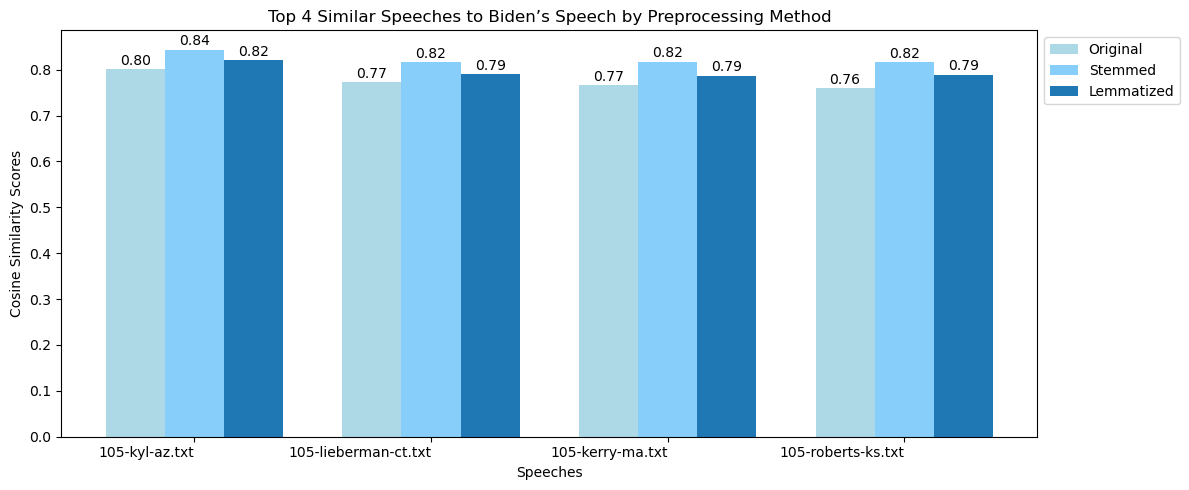

In [12]:
def plot_similarity_comparison(merged_df):
    # Sort and get the top 4 based on original similarity
    top_4 = merged_df.sort_values(by='Similarity_Original', ascending=False).head(4)
    
    fig, ax = plt.subplots(figsize=(12, 5))
    indices = np.arange(len(top_4))  # X positions for the groups
    width = 0.25  # Width of the bars
    
    # Draw the bars
    bars1 = ax.bar(indices - width, top_4['Similarity_Original'], width, label='Original', color='lightblue')
    bars2 = ax.bar(indices, top_4['Similarity_Stemmed'], width, label='Stemmed', color='lightskyblue')
    bars3 = ax.bar(indices + width, top_4['Similarity_Lemmatized'], width, label='Lemmatized')
    
    # Add values on top of each bar
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 1),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    add_labels(bars1)
    add_labels(bars2)
    add_labels(bars3)
    
    # Configure labels and title
    ax.set_xlabel('Speeches')
    ax.set_ylabel('Cosine Similarity Scores')
    ax.set_title('Top 4 Similar Speeches to Biden’s Speech by Preprocessing Method')
    ax.set_xticks(indices)
    ax.set_xticklabels(top_4['FileName'], ha="right")
    ax.legend()
    
    # Place legend outside the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

# Call the plot function with the merged DataFrame
plot_similarity_comparison(merged_df)


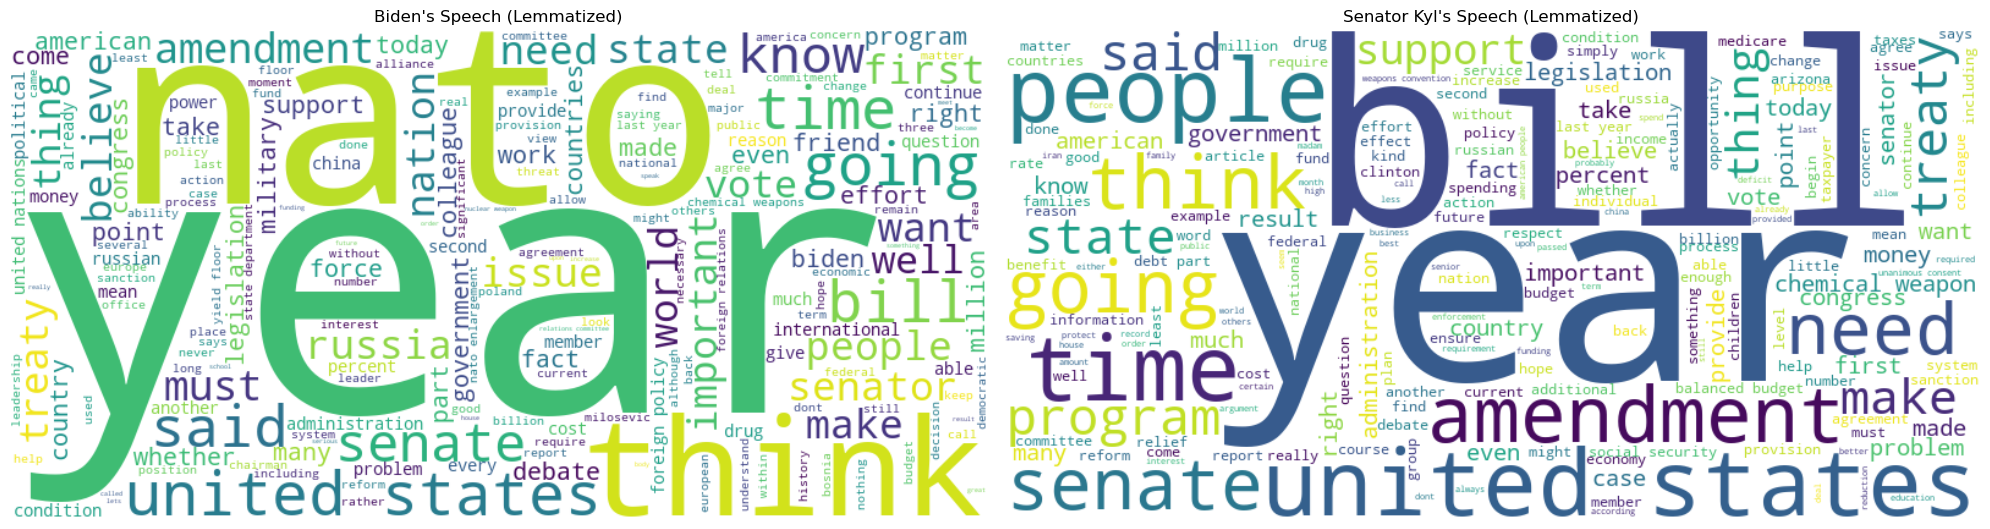

In [13]:
# Function to create a word cloud without displaying it immediately, returning a WordCloud object
def get_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    return wordcloud

# Retrieve lemmatized speeches for Biden and Kyl
biden_lemmatized = preprocess_text(senator_speeches_preprocessed[biden_filename])
kyl_lemmatized = preprocess_text(senator_speeches_preprocessed["105-kyl-az.txt"])

# Now, create word clouds
biden_word_cloud_lemmatized = get_word_cloud(biden_lemmatized)
kyl_word_cloud_lemmatized = get_word_cloud(kyl_lemmatized)

# Display word clouds using subplots for comparison
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Word cloud of Biden's speech after lemmatization
axs[0].imshow(biden_word_cloud_lemmatized, interpolation='bilinear')
axs[0].set_title("Biden's Speech (Lemmatized)")
axs[0].axis('off')

# Word cloud of Senator Kyl's speech after lemmatization
axs[1].imshow(kyl_word_cloud_lemmatized, interpolation='bilinear')
axs[1].set_title("Senator Kyl's Speech (Lemmatized)")
axs[1].axis('off')

plt.tight_layout()
plt.show()


The word cloud plot visualizes the most frequently used words in the speeches of Biden and Kyl senators. These word clouds, with the most prominent words appearing larger, can give us several insights:
- Common Grounds and Divergences: Both individuals frequently use terms like "amendment," "United States," and "Senate," indicating a shared focus on legislative processes and national issues. However, distinct terms also emerge in each word cloud, which may reflect individual priorities or the specific content of the speeches analyzed.
- Legislative Priorities: The prominence of "bill" and "program" alongside "amendment" suggests a strong emphasis on legislative measures and the nitty-gritty of policymaking. This could indicate active engagement in legislative development or debate on the Senate floor.
- Personal Language Style: The use of words like "think," "need," "support," and "want" points towards persuasive language, which is common in political speeches aimed at garnering support for policies or convincing others of a particular viewpoint.
- Political Issues of the Time: Words like "Russia," "China," and "weapon" could indicate discussions on foreign policy or defense, which might have been pertinent issues during the time of these speeches.
Approach to Governance: The appearance of words like "people," "country," and "state" suggests an outward-looking approach, focusing on the constituents and the broader implications of policies.

## 4. Using `sen105kh_fix.csv` as the target variable for predictions.
Based on the evolution of model performances through different approaches, it's clear that text preprocessing and handling class imbalance are crucial steps in predicting the party of a senator from their speech. Here's how each model informed the final strategy and justification for choices made:

##### Prepare dataset for the training

In [14]:
# Rename values for better understanding
df_sen105kh["party"].replace(200, "Republican", inplace=True)
df_sen105kh["party"].replace(100, "Democratic", inplace=True)

# Create a new column 'filename' combining 'cong', 'lname', and 'stateab'
df_sen105kh["filename"] = df_sen105kh["cong"].astype(str) + "-" + df_sen105kh["lname"] + "-" + df_sen105kh["stateab"] + ".txt"
df_sen105kh = df_sen105kh.sort_values(by=["lname"]) # Sort the DataFrame by 'lname'
df_sen105kh = df_sen105kh.reset_index(drop=True) # Reset the index

# Create a DataFrame from 'senator_speeches_preprocessed' for easier handling
speeches_df = pd.DataFrame(list(senator_speeches_preprocessed.items()), columns=['filename', 'speech'])

# Normalize file names to match between 'df_sen105kh' and 'speeches_df'
df_sen105kh['filename'] = df_sen105kh['filename'].str.lower()
speeches_df['filename'] = speeches_df['filename'].str.lower()

# Merge 'df_sen105kh' with 'speeches_df' based on 'filename'
df_sen105kh_merged = pd.merge(df_sen105kh, speeches_df, on='filename', how='left')

# Check the DataFrame after merging
df_sen105kh_merged.head()


,cong,lname,stateab,lstate,id,dist,party,filename,speech
0,105,abraham,mi,MICHIGA,49500,0,Republican,105-abraham-mi.txt,abraham rise today support bill reform product...
1,105,akaka,hi,HAWAII,14400,0,Democratic,105-akaka-hi.txt,akaka today introducing plant protection compr...
2,105,allard,co,COLORAD,29108,0,Republican,105-allard-co.txt,allard proud original sponsor citizen congress...
3,105,ashcroft,mo,MISSOUR,49501,0,Republican,105-ashcroft-mo.txt,ashcroft today exciting introduce along senato...
4,105,baucus,mt,MONTANA,14203,0,Democratic,105-baucus-mt.txt,baucus would like take moment recognize truly ...


In [15]:
# Initialize a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Limit the number of features to reduce dimensionality

# Extract features for the speeches
X_tfidf = tfidf_vectorizer.fit_transform(df_sen105kh_merged['speech'].fillna(''))

# Review the size of the feature matrix
print(X_tfidf.shape)


(100, 1000)


In [16]:
# Extract the 'party' column as labels
y = df_sen105kh_merged['party']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

# Check the size of the training and testing sets
print(X_train.shape, X_test.shape)


(70, 1000) (30, 1000)


##### 4.1. Using Multinomial Naive Bayes
- **Initial Performance**: The first attempt with the Multinomial Naive Bayes model resulted in poor performance, especially for the Democratic class, with an accuracy of 0.4. The model was heavily biased towards predicting 'Republican,' indicating issues with class imbalance and possibly the need for better feature representation.
- **Justification for Changes**: The inability of this model to correctly identify Democratic speeches justified the exploration of methods to address class imbalance and the potential refinement of text preprocessing to improve feature representation.



In [17]:
# Initialize and train the model
model = MultinomialNB()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

  Democratic       0.00      0.00      0.00        18
  Republican       0.40      1.00      0.57        12

    accuracy                           0.40        30
   macro avg       0.20      0.50      0.29        30
weighted avg       0.16      0.40      0.23        30



C:\Users\maiph\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\maiph\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\maiph\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### 4.2. Improvement with Pipeline
- **Pipeline Approach**: The use of a pipeline slightly improved accuracy to 0.53 but did not resolve the bias towards the 'Republican' class. The model still failed to identify any Democratic speeches correctly.
- **Justification for Further Improvement**: While the pipeline streamlined the process of text preprocessing and model application, the persistent issues with class imbalance and the need for more effective feature extraction methods warranted further adjustments.

In [18]:
# Split the data and adjust some parameters
X_train, X_test, y_train, y_test = train_test_split(df_sen105kh_merged['speech'], df_sen105kh_merged['party'], test_size=0.3, random_state=42, stratify=df_sen105kh_merged['party'])

# Creating the pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocess_text)),  # converts documents into a matrix of token counts
    ('tfidf', TfidfTransformer()),  # to perform the TF-IDF transformation
    ('classifier', MultinomialNB()),  # Naive Bayes classifier
])

# Training the model
pipeline.fit(X_train, y_train)

# Making predictions
predictions = pipeline.predict(X_test)

# Evaluating the model
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

  Democratic       0.00      0.00      0.00        14
  Republican       0.53      1.00      0.70        16

    accuracy                           0.53        30
   macro avg       0.27      0.50      0.35        30
weighted avg       0.28      0.53      0.37        30



C:\Users\maiph\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\maiph\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\maiph\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### 4.3. Improvement with SMOTE and ImbPipeline:
- **Use of SMOTE**: The incorporation of SMOTE (Synthetic Minority Over-sampling Technique) through an ImbPipeline significantly improved the model's performance, achieving an accuracy of 0.87 with balanced precision, recall, and F1-scores across both classes.
- **Justification for Choices**: This approach effectively addressed the class imbalance by generating synthetic samples for the minority class, leading to a more balanced and fair model. The use of TF-IDF for feature extraction within this setup likely provided a more nuanced representation of the text data, contributing to the improved accuracy.

In [19]:
#X_train, X_test, y_train, y_test = train_test_split(df_sen105kh_merged['speech'], df_sen105kh_merged['party'], test_size=0.2, random_state=42, stratify=df_sen105kh_merged['party'])

# Create a pipeline with SMOTE and a classifier
pipeline_smote = ImbPipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, ngram_range=(1, 2))),
    ('smote', SMOTE(random_state=42)),
    ('classifier', MultinomialNB())
])

# Train the model
pipeline_smote.fit(X_train, y_train)

# Predict and evaluate
predictions_smote = pipeline_smote.predict(X_test)
print(classification_report(y_test, predictions_smote))


              precision    recall  f1-score   support

  Democratic       0.86      0.86      0.86        14
  Republican       0.88      0.88      0.88        16

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.87      0.87      0.87        30



In [59]:
# Test the accuracy on X_test data
#Due to each senators has very long speeches and my enviroment cannot run all of them
#So I choose randomly 500 character from 
# Function to randomly select 500 character text from each senator to check the prediction
def random_500_chars(text):
    if len(text) <= 500:
        return text
    start_index = random.randint(0, len(text) - 500)
    return text[start_index:start_index + 500]

# Apply the function to each speech in X_test
X_test_shortened = X_test.apply(random_500_chars)

# Convert shortened speeches to a list for prediction
X_test_shortened_list = X_test_shortened.tolist()

# Making predictions
predictions_shortened = pipeline_smote.predict(X_test_shortened_list)
correct_predictions = sum(pred == true for pred, true in zip(predictions_shortened, y_test))
total_predictions = len(predictions_shortened)

print(f"Correct Predictions: {correct_predictions} out of {total_predictions}")
print(f"Accuracy on shortened texts: {correct_predictions / total_predictions:.2f}")


Correct Predictions: 20 out of 30
Accuracy on shortened texts: 0.67
